# Library

In [1]:
# Importing the common libraries
import pandas as pd
import numpy as np

# importing the libraries for data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight

# Importing the libraries for the model
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE, ADASYN
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Importing the libraries for the evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score

# Importing additional libraries
import os
import wget
from pathlib import Path
import shutil
import gzip

In [2]:
# Check if GPU is available print the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


# Dataset

In [3]:
# Set URL and file paths
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
dataset_name = 'forest-cover-type'
tmp_out = Path('./data/'+dataset_name+'.gz')
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [4]:
# Download the file if it does not exist
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, tmp_out.as_posix())
    with gzip.open(tmp_out, 'rb') as f_in:
        with open(out, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

File already exists.


In [5]:
# Define the column names
target = "Covertype"

bool_columns = [
    "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3",
    "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4",
    "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9",
    "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14",
    "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19",
    "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24",
    "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29",
    "Soil_Type30", "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34",
    "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39",
    "Soil_Type40"
]

int_columns = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

feature_columns = (
    int_columns + bool_columns + [target])


In [6]:
# Load the data
train = pd.read_csv(out, header=None, names=feature_columns)

# set total number of data
n_total = len(train)

In [7]:
# Check the first 5 rows
train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Covertype
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [8]:
# Check the data types
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

# Splitting Dataset

In [9]:
# Test train split stratified by Covertype
train_val_indices, test_indices = train_test_split(range(n_total), test_size=0.2, random_state=0, stratify=train[target])
train_indices, valid_indices = train_test_split(train_val_indices, test_size=0.2 / 0.6, random_state=0, stratify=train[target][train_val_indices])

In [10]:
# Check the shape of the data
len(train_indices), len(valid_indices), len(test_indices)

(309872, 154937, 116203)

In [11]:
# Check the distribution of the target
train[target].value_counts(normalize=True)

Covertype
2    0.487599
1    0.364605
3    0.061537
7    0.035300
6    0.029891
5    0.016339
4    0.004728
Name: proportion, dtype: float64

# Preprocessing Data

In [12]:
# Label Encode the target
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

# Define categorical features for categorical embeddings

In [13]:
# Define the features
unused_feat = []

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# Network parameters

In [14]:
# Define the model
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

c:\Users\hasan\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


# Model Traning

In [15]:
if os.getenv("CI", False):
# Take only a subsample to run CI
    X_train = train[features].values[train_indices][:1000,:]
    y_train = train[target].values[train_indices][:1000]
else:
    X_train = train[features].values[train_indices]
    y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [16]:
# Max epochs
max_epochs = 100 if not os.getenv("CI", False) else 5

In [17]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=100,
    batch_size=256, virtual_batch_size=256
) 

epoch 0  | loss: 0.72735 | train_accuracy: 0.7252  | valid_accuracy: 0.72248 |  0:01:27s
epoch 1  | loss: 0.611   | train_accuracy: 0.75889 | valid_accuracy: 0.75658 |  0:02:51s
epoch 2  | loss: 0.54484 | train_accuracy: 0.79613 | valid_accuracy: 0.79344 |  0:04:15s
epoch 3  | loss: 0.49156 | train_accuracy: 0.80389 | valid_accuracy: 0.80012 |  0:05:38s
epoch 4  | loss: 0.46951 | train_accuracy: 0.82575 | valid_accuracy: 0.8212  |  0:07:03s
epoch 5  | loss: 0.42831 | train_accuracy: 0.84507 | valid_accuracy: 0.83964 |  0:08:28s
epoch 6  | loss: 0.39359 | train_accuracy: 0.86267 | valid_accuracy: 0.85703 |  0:09:52s
epoch 7  | loss: 0.36168 | train_accuracy: 0.87294 | valid_accuracy: 0.86749 |  0:11:16s
epoch 8  | loss: 0.34256 | train_accuracy: 0.87709 | valid_accuracy: 0.87008 |  0:12:41s
epoch 9  | loss: 0.3194  | train_accuracy: 0.89001 | valid_accuracy: 0.88286 |  0:14:04s
epoch 10 | loss: 0.30044 | train_accuracy: 0.90058 | valid_accuracy: 0.89339 |  0:15:30s
epoch 11 | loss: 0.28

c:\Users\hasan\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# Plot Loss

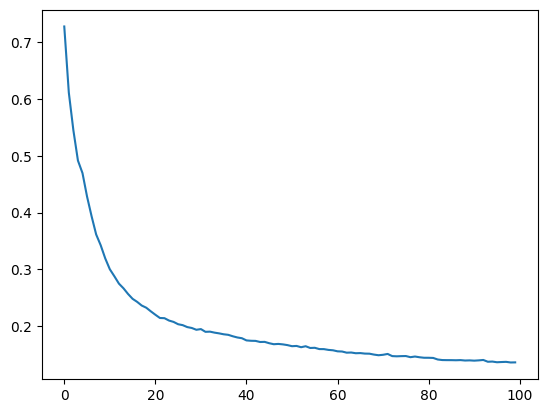

In [18]:
# plot losses
plt.plot(clf.history['loss'])

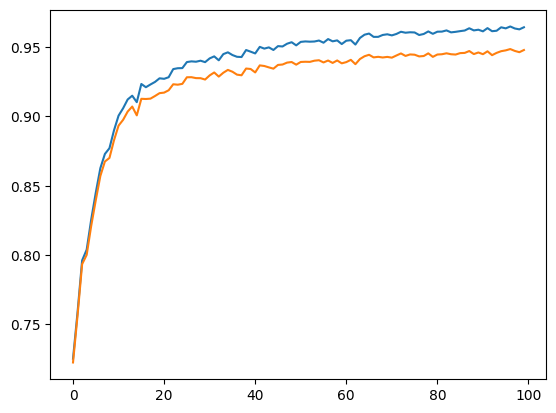

In [19]:
# plot accuracy
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

# Prediction

In [20]:
# To get final results you may need to use a mapping for classes 
# as you are allowed to use targets like ["yes", "no", "maybe", "I don't know"]

preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

preds = clf.predict_proba(X_test)

y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

BEST VALID SCORE FOR forest-cover-type : 0.9486307337821179
FINAL TEST SCORE FOR forest-cover-type : 0.9474368131631713


In [21]:
# or you can simply use the predict method

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

FINAL TEST SCORE FOR forest-cover-type : 0.9474368131631713


# Save and Load

In [22]:
# save state dict
saved_filename = clf.save_model('Model/TabNet_MultiClass')

Successfully saved model at Model/TabNet_MultiClass.zip


In [23]:
# define new model and load save parameters
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filename)

c:\Users\hasan\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
c:\Users\hasan\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:454: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case 

In [24]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_y_pred = np.vectorize(preds_mapper.get)(np.argmax(loaded_preds, axis=1))

loaded_test_acc = accuracy_score(y_pred=loaded_y_pred, y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_acc}")

FINAL TEST SCORE FOR forest-cover-type : 0.9474368131631713
